In [1]:
#!/usr/bin/env python
# -*- coding: latin-1 -*-
import pandas as pd # pandas is a data manipulation library
import numpy as np #provides numerical arrays and functions to manipulate the arrays efficiently
import logging
import difflib
import Levenshtein as lev
from tqdm.notebook import tqdm
import multiprocessing
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy import spatial
import re
import movies_df_helper_functions as helper_fn
import evaluation_helper_functions as eval_fn
import random
import imp
import itertools
from sklearn.manifold import TSNE
from sklearn.cluster import AffinityPropagation
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
import html
import csv
import re
#from sklearn.manifold import TSNE

from tabulate import tabulate
import decimal
from collections import Counter

imp.reload(eval_fn)
imp.reload(helper_fn)
%matplotlib inline

In [2]:
#load train data
#train_data_df = pd.read_csv('models/baseline_exp/train_data.csv')
train_data_df = pd.read_csv('imdb_doc2vec_train_data.csv')
#load genres test data
#genres_sample_df = pd.read_csv('test_data/genres_sample_movies_id_list.csv')
#load all genres lists df
#genres_df = pd.read_csv('test_data/movies_by_genre.csv')
#load all sequel and mixed data for plotting
#sequel_sampled_data_df = pd.read_csv('test_data/sequel_and_sampled_titles_df.csv')

In [14]:
#load model
model = Doc2Vec.load('model')

In [4]:
def assign_genre(genre_df, movie_id):
    romantic_comedy= genre_df.romantic_comedy.values.tolist()
    drama = genre_df.drama.values.tolist()
    adventure = genre_df.adventure.values.tolist()
    crime = genre_df.crime.values.tolist()
    action = genre_df.action.values.tolist()
    
    if movie_id in romantic_comedy:
        return 'Romantic_Comedy'
    else:
        if movie_id in drama:
            return 'Drama'
        else: 
            if movie_id in adventure:
                return 'Adventure'
            else: 
                if movie_id in crime:
                    return 'Crime'
                else: 
                    if movie_id in action: return 'Action'
                    else: 
                        return 'Unkown'

In [ ]:
train_data_df

In [5]:
#Clean train_data_df
#remove the square brackets saved when generating the test data.It i snot a bug. Data can't be saved without as they act as a column separator in the csv file
train_data_df['actor_name'] = train_data_df.actor_name.apply(lambda actor: actor.replace('[','').replace(']','').replace("'", "") )
train_data_df['director_name'] = train_data_df.director_name.apply(lambda director: director.replace('[','').replace(']','').replace("'", "") )
train_data_df['writer_name'] = train_data_df.writer_name.apply(lambda writer: writer.replace('[','').replace(']','').replace("'", "") )
#train_data_df['country'] = train_data_df.country.apply(lambda country: country.replace('[','').replace(']','').replace("'", "") )
train_data_df['genre'] = train_data_df.genre.apply(lambda genre: genre.replace('[','').replace(']','').replace("'", "") )

train_data_df['actor_name'] = train_data_df.actor_name.apply(lambda actor: actor.split(',') )
train_data_df['director_name'] = train_data_df.director_name.apply(lambda director: director.split(',') )
train_data_df['writer_name'] = train_data_df.writer_name.apply(lambda writer: writer.split(',') )
#train_data_df['country'] = train_data_df.country.apply(lambda country: country.split(',') )
train_data_df['genre'] = train_data_df.genre.apply(lambda genre: genre.split(',') )

In [6]:
train_data_df['actor_name'] = train_data_df.actor_name.apply(lambda actor: [a.strip() for a in actor])
train_data_df['director_name'] = train_data_df.director_name.apply(lambda director: [d.strip() for d in director])
train_data_df['writer_name'] = train_data_df.writer_name.apply(lambda writer: [w.strip() for w in writer] )
#train_data_df['country'] = train_data_df.country.apply(lambda country: [c.strip() for c in country] )
train_data_df['genre'] = train_data_df.genre.apply(lambda genre: [g.strip() for g in genre])


train_data_df[train_data_df['movie_id'] == 'agony_(film)'].values

array([], shape=(0, 8), dtype=object)

In [ ]:
train_data_df

In [7]:
#create dictionary with the movie_id and title
movies_dict= dict(zip(train_data_df.movie_id, train_data_df.title))


# Manual Validation

In [11]:
#Manual check
movie_id = 'godzilla:_the_planet_eater_tt8478602'
#movie_id = 'the_bunker_(2001_film)'
#movie_id= 'just_go_with_it_tt1564367'
#movie_id='agony_(film)'
#movie_id= 'harry_potter_and_the_half-blood_prince_tt0417741'
#movie_id = 'toy_story_4_tt1979376'
#movie_id = 'tsar_(film)'
#movie_id='high_school_musical_3:_senior_year'
#movie_id= 'hook_(film)'
#movie_id="alvin_and_the_chipmunks_tt0952640"
#movie_id="blade:_trinity_tt0359013"
movie_id='x-men_tt0120903'
#movie_id="star_trek_enterprise_ii:_der_anfang_vom_ende_tt9899716"
#movie_id='hotel_transylvania_4_tt9848626'
#movie_id="alvin_and_the_chipmunks_tt0952640"

similar_movies = model.docvecs.most_similar(movie_id, topn=10)
sim_movies_list = [sim[0] for sim in similar_movies]

sim_df= pd.DataFrame(columns=['Title','Similarity Ratio'])

for sim in similar_movies:
    #title = helper_fn.find_movie_title_by_id(sim[0], train_data_df)
    data = {'Title':  [sim[0]],'Similarity Ratio': [sim[1]]}
    tmp_df = pd.DataFrame(data, columns=['Title','Similarity Ratio'])
    sim_df = pd.concat([sim_df, tmp_df])   

common_features_df = eval_fn.get_common_attrs_cnt_for_sim_list(train_data_df, sim_movies_list, movie_id,'IMDb') 

result_df = sim_df.merge(common_features_df, left_on= ['Title'], right_on=['Title'], how='inner')

result_df.Title= result_df.Title.map(lambda t: (helper_fn.find_movie_title_by_id(t, train_data_df).values[0]).capitalize())

query_movie_title = helper_fn.find_movie_title_by_id(movie_id, train_data_df).values[0].capitalize()
print("\n")
print("Similarity for the movie title \"{}\"".format(query_movie_title))
display(tabulate(result_df, headers=result_df.columns,tablefmt='html', showindex=False))

#sim = docs_vectors.most_similar(positive= 'harry_potter_and_the_chamber_of_secrets_(film)', topn= 5)
#eval_fn.print_sim_list(similar_movies)



Similarity for the movie title "X-men"


Title,Similarity Ratio,Common Features Count
Guyver: dark hero,0.964105,2
X2: x-men united,0.960906,8
X-men: days of future past,0.954515,7
The usual suspects,0.953072,1
Public access,0.949226,1
Logan,0.946873,4
Alien: covenant,0.945428,1
X-men: apocalypse,0.943511,4
The life and death of peter sellers,0.942235,0
Man of steel,0.94159,3


In [ ]:
imp.reload(eval_fn)

In [ ]:
eval_fn.find_common_attrs(train_data_df, movie_id, 'blade_(film)')

In [ ]:
#Find the count of every feature
sim_movies_deails_df = train_data_df.loc[train_data_df.apply(lambda movie: True if movie.movie_id in sim_movies_list else False, axis=1)]

sim_movies_deails_df.apply(lambda movie: len(movie.actor_name), axis=1)

movie_record = train_data_df[train_data_df.movie_id == movie_id]

def find_feature_cnt_for_movie(movie_record, col):
    col_list = movie_record[col].to_list()
    if col_list is not None:
        return len(col_list[0])
    else:
        return 0

actors = find_feature_cnt_for_movie(movie_record, 'actor_name')

actors

In [ ]:
for s in similar_movies:
    print(s[1])
    

# Visualization

In [ ]:
#prepare data from the same movies used in the manual check
test_movies_list= ['godzilla_vs._biollante'
        ,'the_bunker_(2001_film)'
        ,'just_go_with_it'
        ,'agony_(film)'
        ,'harry_potter_and_the_half-blood_prince_(film)'
        ,'toy_story_4'
        ,'tsar_(film)'
        ,'high_school_musical_3:_senior_year'
        , 'hook_(film)'
        ,"destiny_(1997_film)"
        ]

In [12]:
test_movies_list =['star_trek:_the_motion_picture_tt0079945',
 'toy_story_tt0114709', 'godzilla_tt0047034',
 'iron_man_tt0371746',
 'alvin_and_the_chipmunks_tt0952640', 
 'pitch_perfect_tt1981677',
 'hotel_transylvania_4_tt9848626',
 'the_hunger_games_tt1392170',
 'x-men_tt0120903',
 "harry_potter_and_the_sorcerer's_stone_tt0241527"]

In [ ]:
#Actors

In [ ]:
#query each movie for most similar list
#save each query movie and the result in a dictionary
#for each group, retrieve actors for all the movies in the list

group_by_q_movie=[]
all_groups_actors=[]
for movie_id in test_movies_list:
    sims= model.docvecs.most_similar(movie_id,topn=5)
    g_movies=[]
    for s in sims:
        g_movies.append(s[0])
    group = {'g_id':movie_id, 'g_movies':g_movies}
    group_by_q_movie.append(group)
    
    
for group in group_by_q_movie:
    query_movie_id = group['g_id']
    sim_movies_id_list = group['g_movies']
    group_actors=[]
    group_movies=[]
    actors = helper_fn.find_actors_by_movie_id(query_movie_id, train_data_df)
    
    group_actors = group_actors + actors[0]
    #print(group_actors)
    group_movies.append(query_movie_id)    
   # print("group ID {}".format(query_movie_id))
    
    for movie_id in sim_movies_id_list:
        #print("sim movie id {} :".format(movie_id))
        actors = helper_fn.find_actors_by_movie_id(movie_id, train_data_df)
        group_actors = group_actors + actors[0]
        group_movies.append(movie_id)
        #print(group_actors)
    all_groups_actors.append({'g_id':query_movie_id, 'g_movies':group_movies, 'g_actors':group_actors})


group_actors_df = pd.DataFrame(data= {'movie_id':[g['g_id'] for g in all_groups_actors], 
                'movies_list':[g['g_movies'] for g in all_groups_actors],
               'actors_list':[g['g_actors'] for g in all_groups_actors]
               })


#display(group_actors_df)

data_target_list=[]
movies_target_list=[]
actors_target_list=[]

for group in all_groups_actors:
    movies_target_list = movies_target_list + list(itertools.product([group['g_id']], group['g_movies']))
print(len(movies_target_list))
x_movies_df= pd.DataFrame(data= list(set(movies_target_list)), columns=['Y','X'])
x_movies_df['type']= 'movie'

    
for group in all_groups_actors:
    actors_target_list = actors_target_list + list(itertools.product([group['g_id']], group['g_actors']))
print(len(actors_target_list))
x_actors_df= pd.DataFrame(data= list(set(actors_target_list)), columns=['Y','X'])
x_actors_df['type']= 'actor'

final_df = x_actors_df.append(x_movies_df)

In [ ]:
###Visualization
print(len(final_df))

final_df.reset_index(drop=True, inplace= True)
y=[]
data_X = []
type_x =[]
final_df['title']= final_df.apply(lambda row: helper_fn.find_movie_title_by_id(row.Y,train_data_df).values[0], axis=1)
final_df['title'] = final_df['title'].str.capitalize()
#y_vec = [model[tag] for tag in y]

doctags= model.docvecs.doctags
vocab = model.wv.vocab
final_df = final_df.sample(frac=1)
plt.rcParams["figure.figsize"] = [8,6]
data_X_vec=[]
for tag in final_df['X'].values :                
    if tag in doctags:
        tag_vec= model[tag] 
    else:
        if tag in vocab:
            tag_vec= model.wv[tag] 
        else:
            tag_vec=[0]*50
    data_X_vec.append(tag_vec)
final_df['X_vec']=data_X_vec

tsne=  TSNE(perplexity= 50, n_components=2, init='pca', n_iter=7000, random_state=23)

tsne_obj= tsne.fit_transform(final_df.X_vec.to_list())

tsne_df = pd.DataFrame({'X':tsne_obj[:,0],
                        'Y':tsne_obj[:,1],
                        'movie':final_df.title.to_list(),
                         'X_type':final_df.type.to_list()})

#sns.set(rc={'figure.figsize':(11.7,8.27)})


#movies_only=tsne_df[tsne_df['X_type']=='actor']

In [ ]:
sns.set_context('paper')
palette=['purple','red','orange','brown','blue','dodgerblue','green','lightgreen','darkcyan', 'black']
g = sns.scatterplot(x="X", y="Y", data=tsne_df, palette= palette, hue="movie");

tsne_df.apply(lambda point: g.scatter(point['X'], point['Y'], marker=find_marker(point['X_type'])), axis=1)

              



g.legend(loc='center left', bbox_to_anchor=(1.00, 0.5), ncol=1)


In [ ]:
def find_marker(type_X):
    if type_X == 'movie':
        return "o"
    else:
        if type_X == 'actor':
            return "s"

In [ ]:
movie_id='agony_(film)'
sims= model.docvecs.most_similar(movie_id,topn=5)
eval_fn.calculate_BLEU_score(movie_id, sims,train_data_df)

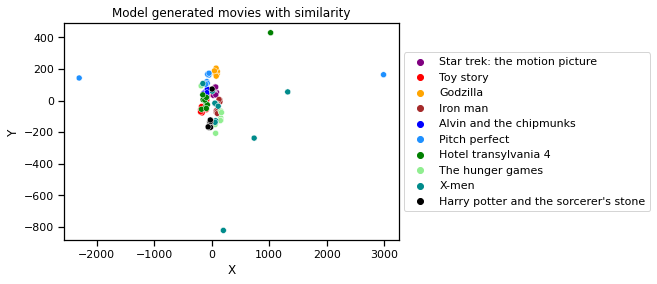

In [15]:
#visialize movies grouped by the query movie_id- for each movie in the test set, generate the sim list and save them in a dict with the query movie as the key
#for each group, plot the query movie and the sim list using distinct color
#generate similarity list for each movie in the test set
vis_group_by_q_movie=[]
for movie_id in test_movies_list:
    sims= model.docvecs.most_similar(movie_id)
    g_movies=[]
    for s in sims:
        g_movies.append(s[0])
    group = {'g_id':movie_id, 'g_movies':g_movies}
    vis_group_by_q_movie.append(group)
#print(vis_group_by_q_movie)    

data_target_list=[]
for group in vis_group_by_q_movie:
    data_target_list = data_target_list + list(itertools.product([group['g_id']], group['g_movies']))
y=[]
data_X = []

#print(data_target_list)

for pair in data_target_list:
    title = helper_fn.find_movie_title_by_id(pair[0],train_data_df)
    y.append(title.values[0].capitalize())
    data_X.append(pair[1])

data_X_vec = [model[tag] for tag in data_X]
tsne=  TSNE(perplexity= 5, n_components=2, init='pca', n_iter=5000, random_state=23)
tsne_obj= tsne.fit_transform(data_X_vec)
tsne_df = pd.DataFrame({'X':tsne_obj[:,0],
                        'Y':tsne_obj[:,1],
                        'movie':y})

sns.set_context("notebook")
g=sns.scatterplot(x="X", y="Y",
              hue="movie",
              palette=['purple','red','orange','brown','blue',
                       'dodgerblue','green','lightgreen','darkcyan', 'black'],
              legend='full',
              data=tsne_df);
plt.title('Model generated movies with similarity')
g.figure.savefig("generated_simialr_movies.png")

g.legend(loc='center left', bbox_to_anchor=(1.00, 0.5), ncol=1)

In [ ]:
def split_list(col):
    

In [ ]:
#further analysis to the results in visualizing the 10 movies and their simialr ones
#get list of genres for each group

all_group_genres_list = []
for group in vis_group_by_q_movie: 
    group_genres_list=[]
    id_genres_list = []
    #genres for the query movie
    movie_genres = helper_fn.find_movie_genre_by_id(group['g_id'], train_data_df)
    id_genres_list = id_genres_list + movie_genres.to_list()[0]
    
    for movie_id in group['g_movies']:
        movie_genres = helper_fn.find_movie_genre_by_id(movie_id, train_data_df)
        group_genres_list = group_genres_list + movie_genres.tolist()[0]
     #   print(group_genres_list[0])
    g_genres={'g_id':group['g_id'], 'q_genres':id_genres_list,'g_genres': list(set(group_genres_list))}
    all_group_genres_list.append(g_genres)

group_genres_df = pd.DataFrame(data= {'movie_id':[g['g_id'] for g in all_group_genres_list]
                                      ,'q_genres':[g['q_genres'] for g in all_group_genres_list]
                                      ,'genres_list':[g['g_genres'] for g in all_group_genres_list]})

group_genres_df['q_genres'] = group_genres_df.apply(lambda row: '|'.join(row['q_genres']), axis=1)
group_genres_df['genres_list'] = group_genres_df.apply(lambda row: '|'.join(row['genres_list']), axis=1)
display(tabulate(group_genres_df, headers=['Query Movie', "Query Movie Genres", "Similar movies genres"],tablefmt='html', showindex=False))
group_genres_df.to_excel("models/exp1/sim_gen_list.xlsx", index=False)
#group_genres_df

# Calculate the ranking score for a model

In [ ]:
#prepare test data
test_titles = []
test_titles= ['shrek','star trek','blade','toy story 4','pitch perfect','harry potter','godzilla','paddington','x-men']
test_data= eval_fn.build_movie_sequel_test_data(train_data_df, test_titles)

rank_score_list = eval_fn.calculate_rank_score(model,test_data,5)
group_rank_df = pd.DataFrame(data= {'group_id':[g['group_id'] for g in rank_score_list], 'score':[g['group_score'] for g in rank_score_list]})
group_rank_df.append(group_rank_df.sum(numeric_only=True), ignore_index=True)
group_rank_df.sort_values(by=['score'], ascending= False, inplace=True)
group_rank_df.loc['Column_Total']= group_rank_df.sum(numeric_only=True, axis=0)
group_rank_df.iloc[len(group_rank_df)-1].group_id= "Total"
display(tabulate(group_rank_df, headers=['Group', "Rank Score"],tablefmt='html', colalign=("right", "left"),showindex=False))

In [ ]:
#Calculate model BLEU score
test_titles = []
test_titles= ['shrek','star trek','blade','toy story 4','pitch perfect','harry potter','godzilla','paddington','x-men']
test_data= eval_fn.build_movie_sequel_test_data(train_data_df, test_titles)
bleu_score = eval_fn.calculate_model_bleu_score(model, test_data, train_data_df, 5)
bleu_score

In [ ]:
test_titles= ['shrek','star trek','blade','toy story 4','pitch perfect','harry potter','godzilla','paddington','x-men']
test_data= eval_fn.build_movie_sequel_test_data(train_data_df, test_titles)
test_data

In [ ]:
len(vis_genres_sample_df)

## visualize movies by genre
#genres_sample_df contains movies from the genres 'Romantic_Comedy','Drama','Adventure','Crime','Action','Unknown'

In [ ]:
y=[]
data_X = []

#print(data_target_list)



vis_genres_sample_df = genres_sample_df.copy()

vis_genres_sample_df['data_X_vec']= vis_genres_sample_df.apply(lambda movie:model[movie.movie_id], axis=1)
vis_genres_sample_df['y']= vis_genres_sample_df.apply(lambda movie: assign_genre(genres_df, movie.movie_id), axis=1)

data_X_vec = list(vis_genres_sample_df['data_X_vec'].values)
y = vis_genres_sample_df['y']
tsne=  TSNE(perplexity= 5, n_components=2, init='pca', n_iter=5000, random_state=23)
tsne_obj= tsne.fit_transform(data_X_vec)
tsne_df = pd.DataFrame({'X':tsne_obj[:,0],
                        'Y':tsne_obj[:,1],
                        'movie':y})
tsne_df.head()
sns.scatterplot(x="X", y="Y",
              data=tsne_df);

g=sns.scatterplot(x="X", y="Y",
              hue="movie",
         #     palette=['purple','red','orange','brown','blue','black'],
              legend='full',
              data=tsne_df);
plt.title('Movies grouped by genre ')
g.legend(loc='center left', bbox_to_anchor=(1.00, 0.5), ncol=1)

## plot sequelmovies with some noise data with labels

In [ ]:
def tsne_plot_doc2vec(model, samples,movies_dict,height, width):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    

    for doc in samples:
        tokens.append(model[doc])
        labels.append(movies_dict[doc])
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(height, width)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
   # plt.ylim(1, -7)
   # plt.xlim(-7,-1)
    
    
    plt.title('Similar and non-similar movies')
    plt.show()
    #plt.figimage.savefig('movies_labels_large.png',  bbox_inches='tight')
    plt.close() 
    

In [ ]:
tsne_plot_doc2vec(model, sequel_sampled_data_df.movie_id,movies_dict,10, 10)

## Not sure what is this for

In [ ]:
def tsne_plot_doc2vec_categorized(model, samples,movies_dict, w,h):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    colors = []
    

    for doc in samples:
        tokens.append(model[doc])
        labels.append(movies_dict[doc])
        colors.append(assign_color(genres_df, doc))
    
    tsne_model = TSNE(perplexity=50, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(w, h)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i],color= colors[i][0] )
        plt.annotate('', #labels[i],
                     xy=(x[i], y[i], ),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
   # plt.xlim(-4.0, -1.0)
  #  display(HTML("<b>%d words most similar to '%s'</b>" % (n,word)))
    plt.title('Movies Distribution by Genre')
    plt.legend( labels=['Romantic_Comedy','Drama','Adventure','Crime','Action','Unknown'])
    plt.savefig('movies_genre.png')
   # plt.show(block=False)
    plt.show()
genres_sample_df

In [ ]:
tsne_plot_doc2vec_categorized(model, set(genres_sample_df[0:100].movie_id), movies_dict, 12,12)

In [ ]:
genre_samples= genres_sample_df.movie_id.values.tolist()
len(genre_samples)

In [83]:
col_data=train_data_df[col_name]
val_list=[]
for data in col_data:
    for val in data:
        val_list.append(val)
occurence_count = Counter(val_list)
high_cnt = occurence_count.most_common(10)[0:10]
x= [cnt[0] for cnt in high_cnt ]


In [ ]:
tsne_plot_doc2vec(model, set(genre_samples[0:100]), movies_dict)

In [ ]:
from seaborn import sns

In [16]:
#Plot movies by features

def plot_movies_by_feature(col_name, train_data_df, sample_size):
    col_data=train_data_df[col_name]
    val_list=[]
    for data in col_data:
        for val in data:
            val_list.append(val)

    occurence_count = Counter(val_list)
    print(len(occurence_count))
    high_cnt = occurence_count.most_common(sample_size)[0:sample_size]
    val_list= [cnt[0] for cnt in high_cnt ]
    print(val_list)
    
    movies_val_dict={}

    #val_list = random.sample(val_list,sample_size)
    for val in val_list:
        movies_val_dict[val] = helper_fn.find_movies_by_col_value(col_name, val, train_data_df)    
    
    data_target_list=[]
    for key in val_list:
        for val in movies_val_dict[key]:
            data_target_list.append((key,val))
    y=[]
    data_X = []

    for pair in data_target_list:
        y.append(pair[0])
        data_X.append(pair[1])

    data_X_vec = [model[tag] for tag in data_X]
    sns.set_context('notebook')
    tsne=  TSNE(perplexity= 50, n_components=2, init='pca', n_iter=5000, random_state=23)
    tsne_obj= tsne.fit_transform(data_X_vec)
    tsne_df = pd.DataFrame({'X':tsne_obj[:,0],
                        'Y':tsne_obj[:,1],
                        col_name:y})
    return tsne_df

def draw_plot(tsne_df, col_name, title,filename):
   # sns.set_palette(sns.color_palette("default", 20))
    #sns.color_palette()
    tsne_df[col_name] = tsne_df[col_name].apply(lambda c: c[1:] if c.startswith('_') else c)
    g=sns.scatterplot(x="X", y="Y",
                  hue=col_name,
              #    hue_order= cat_order,
                #  palette=['purple','red','orange'],
                  legend= 'full',            
                  data=tsne_df);
    
    g.set_title(title)
    #g.set_xlim(-600, 800)
    #g.set_ylim(-800, 600)
    g.legend(loc='center left', bbox_to_anchor=(1.00, 0.5), ncol=1)
    g.figure.savefig(filename)
    plt.close
    
        
    

In [ ]:
sample_size= 5
col_name= 'actor_name' #10 actors
col_name='writer_name' #10 samples
col_name='director_name' #10
#col_name='country' #10 samples
col_name='genre' #top 10

plot_df = plot_movies_by_feature(col_name,train_data_df, sample_size)
title= "Movies grouped by "+col_name
filename= col_name+"_plot.png"

28
['drama', 'comedy', 'romance', 'action', 'crime']


In [25]:
draw_plot(plot_df,col_name, title,filename )

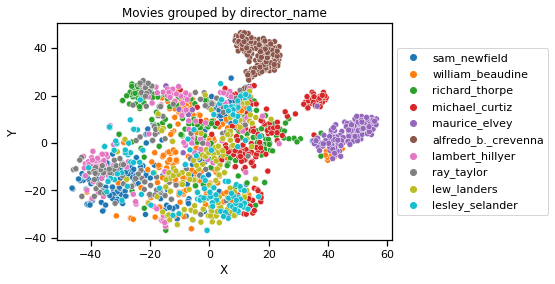

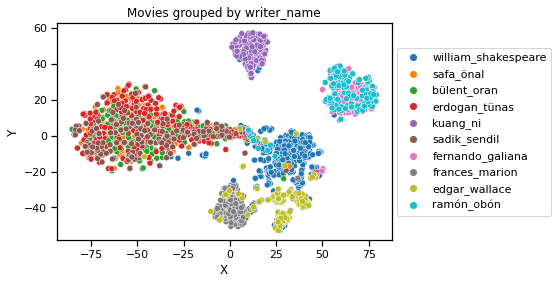

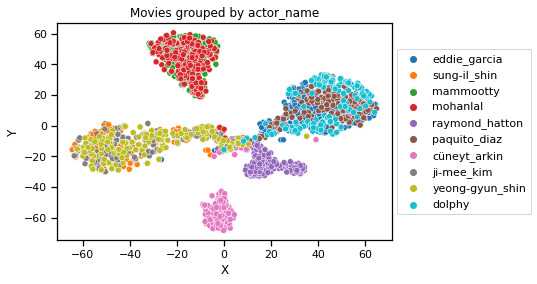

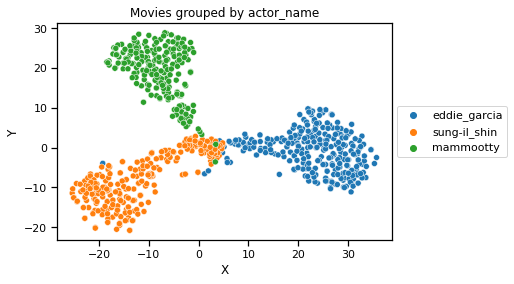

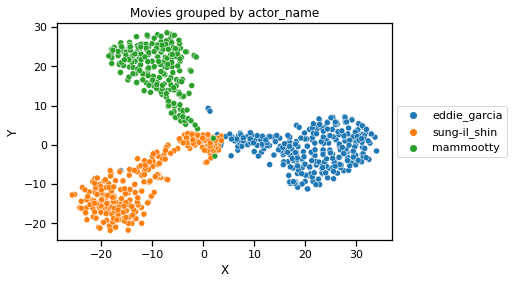

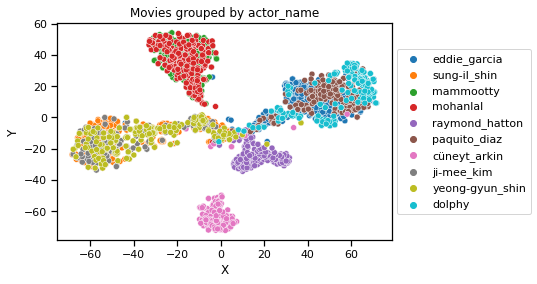

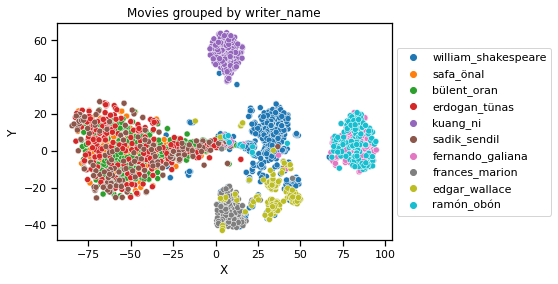

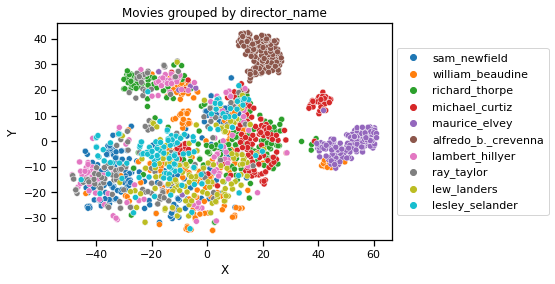

In [68]:
startrek_list=['star_trek:_the_motion_picture_tt0079945',
'star_trek_ii:_the_wrath_of_khan_tt0084726',
'star_trek_vi:_the_undiscovered_country_tt0102975',
'star_trek:_generations_tt0111280',
'star_trek:_nemesis_tt0253754',
'star_trek_tt0796366',
'star_trek:_operation_beta_shield_tt1206087',
'star_trek_into_darkness_tt1408101',
'star_trek_beyond_tt2660888',
'star_trek:_horizon_tt3854562',
'star_trek:_captain_pike_tt4669408',
'star_trek:_the_paradise_makers_tt7264946',
'star_trek:_the_infinite_chain_tt9870502',
'star_trek:_the_final_darkness_tt9876412']
    
eval_fn.find_common_attrs_in_list(train_data_df, 'star_trek_tt0796366',startrek_list,'IMDb' )

title                                               [star trek]
star_trek:_the_motion_picture_tt0079945                       4
star_trek_ii:_the_wrath_of_khan_tt0084726                     5
star_trek_vi:_the_undiscovered_country_tt0102975              5
star_trek:_generations_tt0111280                              3
star_trek:_nemesis_tt0253754                                  4
star_trek_tt0796366                                          11
star_trek:_operation_beta_shield_tt1206087                    2
star_trek_into_darkness_tt1408101                             9
star_trek_beyond_tt2660888                                    7
star_trek:_horizon_tt3854562                                  4
star_trek:_captain_pike_tt4669408                             4
star_trek:_the_paradise_makers_tt7264946                      2
star_trek:_the_infinite_chain_tt9870502                       2
star_trek:_the_final_darkness_tt9876412                       2
dtype: object

In [62]:
toystory_list=['toy_story_tt0114709',
'toy_story_2_tt0120363',
'toy_story_3_tt0435761',
'toy_story_4_tt1979376']
eval_fn.find_common_attrs_in_list(train_data_df, 'toy_story_tt0114709',toystory_list,'IMDb' )

title                    [toy story]
toy_story_tt0114709               13
toy_story_2_tt0120363              8
toy_story_3_tt0435761              6
toy_story_4_tt1979376              6
dtype: object

In [61]:
godzilla_list=['godzilla_tt0047034',
'godzilla_raids_again_tt0048127',
'godzilla:_king_of_the_monsters!_tt0197521',
'godzilla_tt12182062',
'godzilla_vs._wolfman_tt5567368',
] 
eval_fn.find_common_attrs_in_list(train_data_df, 'godzilla_tt0047034',godzilla_list,'IMDb' )

title                                        [godzilla]
godzilla_tt0047034                                   12
godzilla_raids_again_tt0048127                        6
godzilla:_king_of_the_monsters!_tt0197521            10
godzilla_tt12182062                                   6
godzilla_vs._wolfman_tt5567368                        4
dtype: object

In [60]:
harry_list=["harry_potter_and_the_sorcerer's_stone_tt0241527",
'harry_potter_and_the_chamber_of_secrets_tt0295297',
'harry_potter_and_the_prisoner_of_azkaban_tt0304141',
'harry_potter_and_the_goblet_of_fire_tt0330373',
'harry_potter_and_the_order_of_the_phoenix_tt0373889',
'harry_potter_and_the_half-blood_prince_tt0417741',
'harry_potter_and_the_deathly_hallows:_part_1_tt0926084',
'harry_potter_and_the_deathly_hallows:_part_2_tt1201607']
eval_fn.find_common_attrs_in_list(train_data_df, 'harry_potter_and_the_sorcerer\'s_stone_tt0241527',harry_list,'IMDb' )

title                                                     [harry potter and the sorcerer's stone]
harry_potter_and_the_sorcerer's_stone_tt0241527                                                10
harry_potter_and_the_chamber_of_secrets_tt0295297                                               9
harry_potter_and_the_prisoner_of_azkaban_tt0304141                                              7
harry_potter_and_the_goblet_of_fire_tt0330373                                                   7
harry_potter_and_the_order_of_the_phoenix_tt0373889                                             5
harry_potter_and_the_half-blood_prince_tt0417741                                                6
harry_potter_and_the_deathly_hallows:_part_1_tt0926084                                          7
harry_potter_and_the_deathly_hallows:_part_2_tt1201607                                          6
dtype: object

In [59]:
xmen_list=['x-men_tt0120903',
'x-men:_the_last_stand_tt0376994',
'x-men_origins:_wolverine_tt0458525',
'x-men:_first_class_tt1270798',
'x-men:_days_of_future_past_tt1877832',
'x-men:_apocalypse_tt3385516']
eval_fn.find_common_attrs_in_list(train_data_df, 'x-men_tt0120903',xmen_list,'IMDb' )

title                                   [x-men]
x-men_tt0120903                              10
x-men:_the_last_stand_tt0376994               6
x-men_origins:_wolverine_tt0458525            4
x-men:_first_class_tt1270798                  3
x-men:_days_of_future_past_tt1877832          7
x-men:_apocalypse_tt3385516                   4
dtype: object

In [56]:
hungergames_list=['the_hunger_games_tt1392170',
'the_hunger_games:_catching_fire_tt1951264',
'the_hunger_games:_mockingjay_-_part_1_tt1951265',
'the_hunger_games:_mockingjay_-_part_2_tt1951266'
]
eval_fn.find_common_attrs_in_list(train_data_df, 'the_hunger_games:_catching_fire_tt1951264',hungergames_list,'IMDb' )

title                                              [x-men]
the_hunger_games_tt1392170                               3
the_hunger_games:_catching_fire_tt1951264                2
the_hunger_games:_mockingjay_-_part_1_tt1951265          3
the_hunger_games:_mockingjay_-_part_2_tt1951266          3
dtype: object

In [51]:
hoteltrans_list=[
'hotel_transylvania_4_tt9848626',
'hotel_transylvania_tt0837562',
'hotel_transylvania_2_tt2510894',
'hotel_transylvania_3:_summer_vacation_tt5220122'   
]
eval_fn.find_common_attrs_in_list(train_data_df, 'hotel_transylvania_4_tt9848626',hoteltrans_list,'IMDb' )

title                                                         [hotel transylvania 4]
hotel_transylvania_4_tt9848626hotel_transylvania_tt0837562                         0
hotel_transylvania_2_tt2510894                                                     6
hotel_transylvania_3:_summer_vacation_tt5220122                                    6
dtype: object

In [45]:
pitchperfect_list =['pitch_perfect_tt1981677',
'pitch_perfect_2_tt2848292',
'pitch_perfect_3_tt4765284']
eval_fn.find_common_attrs_in_list(train_data_df, 'pitch_perfect_tt1981677',pitchperfect_list,'IMDb' )

title                        [pitch perfect]
pitch_perfect_tt1981677                   10
pitch_perfect_2_tt2848292                  7
pitch_perfect_3_tt4765284                  8
dtype: object

In [36]:
alvin_list=['alvin_and_the_chipmunks_tt0952640', 
'alvin_and_the_chipmunks:_the_squeakquel_tt1231580',
'alvin_and_the_chipmunks:_chipwrecked_tt1615918',
'alvin_and_the_chipmunks:_the_road_chip_tt2974918']
eval_fn.find_common_attrs_in_list(train_data_df, 'alvin_and_the_chipmunks_tt0952640',alvin_list,'IMDb' )

title                                                [alvin and the chipmunks]
alvin_and_the_chipmunks_tt0952640                                           12
alvin_and_the_chipmunks:_the_squeakquel_tt1231580                            7
alvin_and_the_chipmunks:_chipwrecked_tt1615918                               5
alvin_and_the_chipmunks:_the_road_chip_tt2974918                             5
dtype: object

In [42]:
ironman_list=[
 'iron_man_tt0371746',
    
 'iron_man_2_tt1228705',
 'iron_man_3_tt1300854'
]
eval_fn.find_common_attrs_in_list(train_data_df, 'iron_man_2_tt1228705',ironman_list,'IMDb' )

title                   [iron man 2]
iron_man_tt0371746                 7
iron_man_2_tt1228705              13
iron_man_3_tt1300854              10
dtype: object

In [69]:
sequel_list=startrek_list+toystory_list+godzilla_list+harry_list+xmen_list+hungergames_list+hoteltrans_list+pitchperfect_list+alvin_list+ironman_list

In [79]:
sequel_data_df= train_data_df.loc[train_data_df.apply(lambda row: True if row.movie_id in sequel_list else False, axis=1)]

In [80]:
sequel_data_df.to_csv("sequel_test_data.csv", index=False)

In [ ]:
len(plot_df)

In [ ]:
def show_closest_line(similar_movies, query_movie, n):
   # display(html.HTML("<b>%d words most similar to '%s'</b>" % (n, query_movie)))
    
    tops = similar_movies
    
    items = [item[0] for item in tops]
    sims = [item[1] for i,item in enumerate(tops)]
    
    fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)

    
    plt.xticks(range(n), [i+1 for i in range(n)])
    plt.xlabel('Rank')
    plt.ylabel('Similarity')
    plt.xlim(-1,n)

    
    ax.plot(sims, color="purple", alpha=0.5)
    
    for item, x, y in zip(items, range(n), sims):
        ax.annotate( item, xy=(x, y), xytext=(20, -7), textcoords='offset points', 
                     ha='right', va='bottom', color='orange', fontsize=14 )

    
    
    
    plt.show()